In [1]:
# ============================================================
# IMPORTS
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    precision_recall_curve, roc_curve, roc_auc_score
)

from xgboost import XGBClassifier

# Add parent directory to path for preprocessing import
sys.path.append('scripts')
from preprocessing import preprocess

import warnings
warnings.filterwarnings('ignore')



In [2]:
# ============================================================
# RUN PREPROCESSING
# ============================================================

# Run preprocessing function directly
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(
    data_path='data/raw/HR_Attrition_Dataset.csv'
)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nFeatures: {list(X_train.columns)}")
print(f"\nClass distribution (Training):")
print(y_train.value_counts(normalize=True).round(3))


Kept 14 columns from original dataset

Final feature shapes:
  X_train: (882, 18)
  X_val: (294, 18)
  X_test: (294, 18)

Total features: 18
Training set: 882 samples, 18 features
Validation set: 294 samples
Test set: 294 samples

Features: ['JobSatisfaction', 'JobInvolvement', 'EnvironmentSatisfaction', 'JobRole_Research Director', 'JobRole_Sales Representative', 'BusinessTravel_Travel_Frequently', 'WorkLifeBalance', 'Department_Research & Development', 'YearsAtCompanyLog', 'TotalWorkingYearsLog', 'MaritalStatus_Single', 'OverTime_Yes', 'JobRole_Laboratory Technician', 'JobRole_Manufacturing Director', 'MaritalStatus_Married', 'JobRole_Manager', 'NumCompaniesWorked', 'JobRole_Healthcare Representative']

Class distribution (Training):
Attrition
0    0.838
1    0.162
Name: proportion, dtype: float64


In [3]:
# ============================================================
# CLASS IMBALANCE - CALCULATE SCALE_POS_WEIGHT
# ============================================================

# XGBoost uses scale_pos_weight to handle imbalance
# Recommended: (number of negative samples) / (number of positive samples)

n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive

print(f"Class 0 (Stay): {n_negative}")
print(f"Class 1 (Leave): {n_positive}")
print(f"Imbalance ratio: {scale_pos_weight:.2f}")
print(f"\nRecommended scale_pos_weight: {scale_pos_weight:.2f}")


Class 0 (Stay): 739
Class 1 (Leave): 143
Imbalance ratio: 5.17

Recommended scale_pos_weight: 5.17


In [4]:
# ============================================================
# XGBOOST HYPERPARAMETER TUNING WITH GRIDSEARCHCV
# ============================================================

# Set up StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


# Simplified hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [scale_pos_weight, scale_pos_weight * 2, scale_pos_weight * 3]
}
# Total combinations: 3 × 3 × 3 × 3 = 81


# Base classifier
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0
)


# GridSearchCV with F1 scoring
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1',
    cv=skf,
    verbose=2,
    n_jobs=-1
)


# Fit model
grid_search.fit(X_train, y_train)


print("\n" + "=" * 60)
print("GRIDSEARCHCV RESULTS")
print("=" * 60)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best F1 Score (CV): {grid_search.best_score_:.4f}")


# Best estimator
best_xgb = grid_search.best_estimator_


# --- Try with Grid Search (more parameters) and save parameters ---

Fitting 5 folds for each of 81 candidates, totalling 405 fits

GRIDSEARCHCV RESULTS
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'scale_pos_weight': np.float64(10.335664335664335)}
Best F1 Score (CV): 0.5005


In [5]:
# ============================================================
# THRESHOLD OPTIMIZATION - DUAL STRATEGY
# 1. F1-Optimized: Best balance between precision and recall
# 2. Recall-Optimized: Minimize surprise departures
# ============================================================

# Get predicted probabilities on validation set
y_val_proba = best_xgb.predict_proba(X_val)[:, 1]

# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)

# ---- F1-OPTIMIZED THRESHOLD ----
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)
best_f1_idx = np.argmax(f1_scores)
f1_optimal_threshold = thresholds[best_f1_idx]
f1_achieved_recall = recalls[best_f1_idx]
f1_achieved_precision = precisions[best_f1_idx]
f1_achieved_f1 = f1_scores[best_f1_idx]

# ---- RECALL-OPTIMIZED THRESHOLD ----
TARGET_RECALL = 0.70  # Catch at least 80% of leavers

valid_indices = np.where(recalls[:-1] >= TARGET_RECALL)[0]

if len(valid_indices) > 0:
    best_idx = valid_indices[np.argmax(precisions[:-1][valid_indices])]
    recall_optimal_threshold = thresholds[best_idx]
    recall_achieved_recall = recalls[best_idx]
    recall_achieved_precision = precisions[best_idx]
else:
    recall_optimal_threshold = thresholds[0]
    recall_achieved_recall = recalls[0]
    recall_achieved_precision = precisions[0]
    print(f"WARNING: Target recall {TARGET_RECALL:.0%} not achievable. Using lowest threshold.")

print("=" * 60)
print("THRESHOLD OPTIMIZATION RESULTS")
print("=" * 60)
print(f"\n{'F1-OPTIMIZED THRESHOLD':^60}")
print(f"Threshold: {f1_optimal_threshold:.3f}")
print(f"Precision: {f1_achieved_precision:.2%}")
print(f"Recall: {f1_achieved_recall:.2%}")
print(f"F1 Score: {f1_achieved_f1:.3f}")

print(f"\n{'RECALL-OPTIMIZED THRESHOLD':^60}")
print(f"Target Recall: {TARGET_RECALL:.0%}")
print(f"Threshold: {recall_optimal_threshold:.3f}")
print(f"Precision: {recall_achieved_precision:.2%}")
print(f"Recall: {recall_achieved_recall:.2%}")
print("=" * 60)


THRESHOLD OPTIMIZATION RESULTS

                   F1-OPTIMIZED THRESHOLD                   
Threshold: 0.830
Precision: 66.67%
Recall: 42.55%
F1 Score: 0.519

                 RECALL-OPTIMIZED THRESHOLD                 
Target Recall: 70%
Threshold: 0.011
Precision: 24.09%
Recall: 70.21%


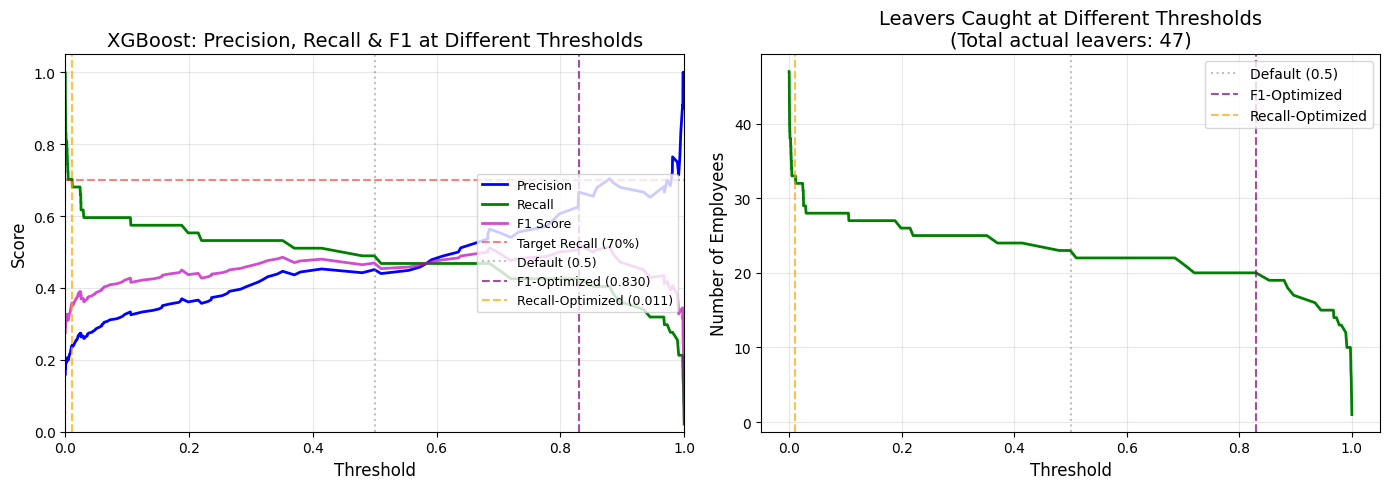

In [6]:
# ============================================================
# VISUALIZATION: Precision-Recall Trade-off by Threshold
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Precision and Recall vs Threshold
ax1 = axes[0]
ax1.plot(thresholds, precisions[:-1], 'b-', label='Precision', linewidth=2)
ax1.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
ax1.plot(thresholds, f1_scores, 'm-', label='F1 Score', linewidth=2, alpha=0.7)
ax1.axhline(y=TARGET_RECALL, color='r', linestyle='--', alpha=0.5, 
            label=f'Target Recall ({TARGET_RECALL:.0%})')
ax1.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5, label='Default (0.5)')
ax1.axvline(x=f1_optimal_threshold, color='purple', linestyle='--', alpha=0.7, 
            label=f'F1-Optimized ({f1_optimal_threshold:.3f})')
ax1.axvline(x=recall_optimal_threshold, color='orange', linestyle='--', alpha=0.7, 
            label=f'Recall-Optimized ({recall_optimal_threshold:.3f})')
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('XGBoost: Precision, Recall & F1 at Different Thresholds', fontsize=14)
ax1.legend(loc='center right', fontsize=9)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1.05])
ax1.grid(True, alpha=0.3)

# Plot 2: Business Impact - Leavers caught at each threshold
ax2 = axes[1]
n_actual_leavers = y_val.sum()
leavers_caught = recalls[:-1] * n_actual_leavers

ax2.plot(thresholds, leavers_caught, 'g-', linewidth=2)
ax2.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5, label='Default (0.5)')
ax2.axvline(x=f1_optimal_threshold, color='purple', linestyle='--', alpha=0.7,
            label=f'F1-Optimized')
ax2.axvline(x=recall_optimal_threshold, color='orange', linestyle='--', alpha=0.7,
            label=f'Recall-Optimized')
ax2.set_xlabel('Threshold', fontsize=12)
ax2.set_ylabel('Number of Employees', fontsize=12)
ax2.set_title(f'Leavers Caught at Different Thresholds\n(Total actual leavers: {n_actual_leavers:.0f})', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [7]:
# ============================================================
# VALIDATION SET EVALUATION - ALL THREE THRESHOLDS
# ============================================================

# Predictions with all three thresholds
y_val_pred_default = (y_val_proba >= 0.5).astype(int)
y_val_pred_f1 = (y_val_proba >= f1_optimal_threshold).astype(int)
y_val_pred_recall = (y_val_proba >= recall_optimal_threshold).astype(int)

print("=" * 60)
print("VALIDATION SET - DEFAULT THRESHOLD (0.5)")
print("=" * 60)
print(classification_report(y_val, y_val_pred_default, target_names=['Stay', 'Leave']))

print("=" * 60)
print(f"VALIDATION SET - F1-OPTIMIZED THRESHOLD ({f1_optimal_threshold:.3f})")
print("=" * 60)
print(classification_report(y_val, y_val_pred_f1, target_names=['Stay', 'Leave']))

print("=" * 60)
print(f"VALIDATION SET - RECALL-OPTIMIZED THRESHOLD ({recall_optimal_threshold:.3f})")
print("=" * 60)
print(classification_report(y_val, y_val_pred_recall, target_names=['Stay', 'Leave']))


VALIDATION SET - DEFAULT THRESHOLD (0.5)
              precision    recall  f1-score   support

        Stay       0.90      0.89      0.89       247
       Leave       0.44      0.47      0.45        47

    accuracy                           0.82       294
   macro avg       0.67      0.68      0.67       294
weighted avg       0.82      0.82      0.82       294

VALIDATION SET - F1-OPTIMIZED THRESHOLD (0.830)
              precision    recall  f1-score   support

        Stay       0.90      0.96      0.93       247
       Leave       0.67      0.43      0.52        47

    accuracy                           0.87       294
   macro avg       0.78      0.69      0.72       294
weighted avg       0.86      0.87      0.86       294

VALIDATION SET - RECALL-OPTIMIZED THRESHOLD (0.011)
              precision    recall  f1-score   support

        Stay       0.91      0.58      0.71       247
       Leave       0.24      0.70      0.36        47

    accuracy                           0.

In [8]:
# ============================================================
# TEST SET EVALUATION - ALL THREE THRESHOLDS
# ============================================================

# Get test predictions
y_test_proba = best_xgb.predict_proba(X_test)[:, 1]
y_test_pred_default = (y_test_proba >= 0.5).astype(int)
y_test_pred_f1 = (y_test_proba >= f1_optimal_threshold).astype(int)
y_test_pred_recall = (y_test_proba >= recall_optimal_threshold).astype(int)

print("=" * 60)
print("TEST SET - DEFAULT THRESHOLD (0.5)")
print("=" * 60)
print(classification_report(y_test, y_test_pred_default, target_names=['Stay', 'Leave']))

print("=" * 60)
print(f"TEST SET - F1-OPTIMIZED THRESHOLD ({f1_optimal_threshold:.3f})")
print("=" * 60)
print(classification_report(y_test, y_test_pred_f1, target_names=['Stay', 'Leave']))

print("=" * 60)
print(f"TEST SET - RECALL-OPTIMIZED THRESHOLD ({recall_optimal_threshold:.3f})")
print("=" * 60)
print(classification_report(y_test, y_test_pred_recall, target_names=['Stay', 'Leave']))

# Business metrics comparison
cm_default = confusion_matrix(y_test, y_test_pred_default)
cm_f1 = confusion_matrix(y_test, y_test_pred_f1)
cm_recall = confusion_matrix(y_test, y_test_pred_recall)

print("\n" + "=" * 75)
print("BUSINESS IMPACT COMPARISON - TEST SET")
print("=" * 75)
print(f"{'Metric':<30} {'Default':>12} {'F1-Opt':>12} {'Recall-Opt':>12}")
print("-" * 75)
print(f"{'Threshold':<30} {'0.500':>12} {f1_optimal_threshold:>12.3f} {recall_optimal_threshold:>12.3f}")
print(f"{'Leavers Caught (TP)':<30} {cm_default[1,1]:>12} {cm_f1[1,1]:>12} {cm_recall[1,1]:>12}")
print(f"{'Missed Departures (FN)':<30} {cm_default[1,0]:>12} {cm_f1[1,0]:>12} {cm_recall[1,0]:>12}")
print(f"{'False Alarms (FP)':<30} {cm_default[0,1]:>12} {cm_f1[0,1]:>12} {cm_recall[0,1]:>12}")
print(f"{'Correct Stay Predictions (TN)':<30} {cm_default[0,0]:>12} {cm_f1[0,0]:>12} {cm_recall[0,0]:>12}")
print("=" * 75)

# Calculate percentages
total_leavers = cm_default[1,0] + cm_default[1,1]
print(f"\n{'Recall (% Leavers Caught)':<30} {cm_default[1,1]/total_leavers:>11.1%} {cm_f1[1,1]/total_leavers:>12.1%} {cm_recall[1,1]/total_leavers:>12.1%}")
print(f"{'Precision (% Correct Flags)':<30} {cm_default[1,1]/(cm_default[1,1]+cm_default[0,1]):>11.1%} {cm_f1[1,1]/(cm_f1[1,1]+cm_f1[0,1]):>12.1%} {cm_recall}")

TEST SET - DEFAULT THRESHOLD (0.5)
              precision    recall  f1-score   support

        Stay       0.88      0.89      0.89       247
       Leave       0.40      0.36      0.38        47

    accuracy                           0.81       294
   macro avg       0.64      0.63      0.63       294
weighted avg       0.80      0.81      0.81       294

TEST SET - F1-OPTIMIZED THRESHOLD (0.830)
              precision    recall  f1-score   support

        Stay       0.87      0.94      0.90       247
       Leave       0.45      0.28      0.34        47

    accuracy                           0.83       294
   macro avg       0.66      0.61      0.62       294
weighted avg       0.80      0.83      0.81       294

TEST SET - RECALL-OPTIMIZED THRESHOLD (0.011)
              precision    recall  f1-score   support

        Stay       0.90      0.58      0.71       247
       Leave       0.23      0.66      0.34        47

    accuracy                           0.60       294
   ma

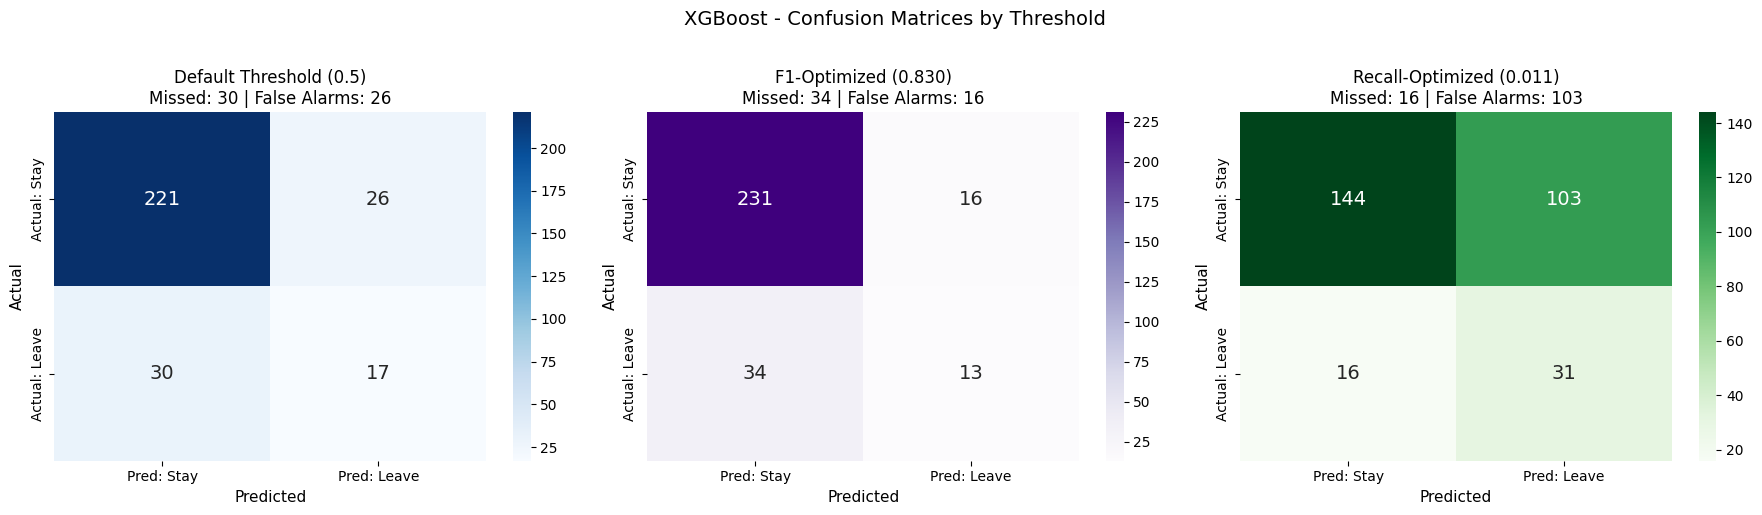

In [9]:
# ============================================================
# CONFUSION MATRICES: Default vs F1-Optimized vs Recall-Optimized
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Default threshold
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred: Stay', 'Pred: Leave'],
            yticklabels=['Actual: Stay', 'Actual: Leave'],
            annot_kws={'size': 14})
axes[0].set_title(f'Default Threshold (0.5)\nMissed: {cm_default[1,0]} | False Alarms: {cm_default[0,1]}', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_xlabel('Predicted', fontsize=11)

# F1-optimized threshold
sns.heatmap(cm_f1, annot=True, fmt='d', cmap='Purples', ax=axes[1],
            xticklabels=['Pred: Stay', 'Pred: Leave'],
            yticklabels=['Actual: Stay', 'Actual: Leave'],
            annot_kws={'size': 14})
axes[1].set_title(f'F1-Optimized ({f1_optimal_threshold:.3f})\nMissed: {cm_f1[1,0]} | False Alarms: {cm_f1[0,1]}', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=11)
axes[1].set_xlabel('Predicted', fontsize=11)

# Recall-optimized threshold
sns.heatmap(cm_recall, annot=True, fmt='d', cmap='Greens', ax=axes[2],
            xticklabels=['Pred: Stay', 'Pred: Leave'],
            yticklabels=['Actual: Stay', 'Actual: Leave'],
            annot_kws={'size': 14})
axes[2].set_title(f'Recall-Optimized ({recall_optimal_threshold:.3f})\nMissed: {cm_recall[1,0]} | False Alarms: {cm_recall[0,1]}', fontsize=12)
axes[2].set_ylabel('Actual', fontsize=11)
axes[2].set_xlabel('Predicted', fontsize=11)

plt.suptitle('XGBoost - Confusion Matrices by Threshold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


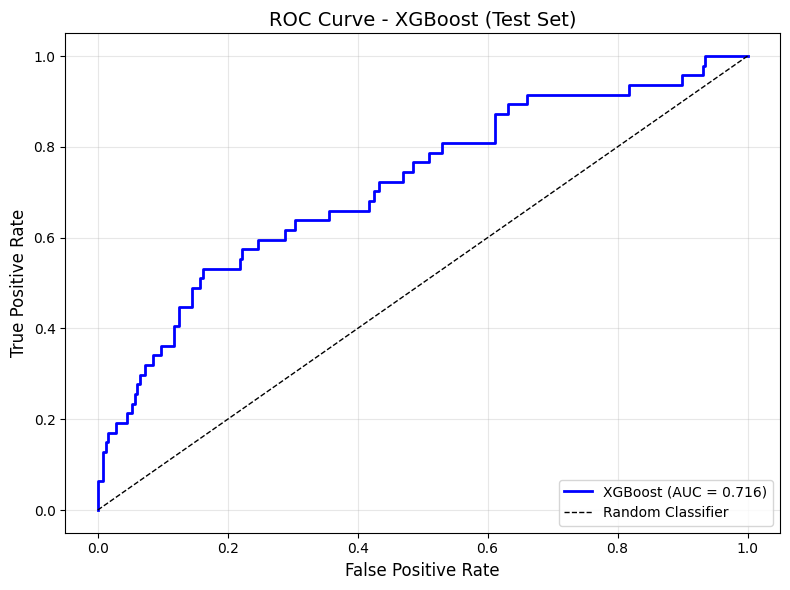

AUC Score: 0.7164


In [10]:
# ============================================================
# ROC CURVE
# ============================================================

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
auc_score = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'XGBoost (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - XGBoost (Test Set)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC Score: {auc_score:.4f}")


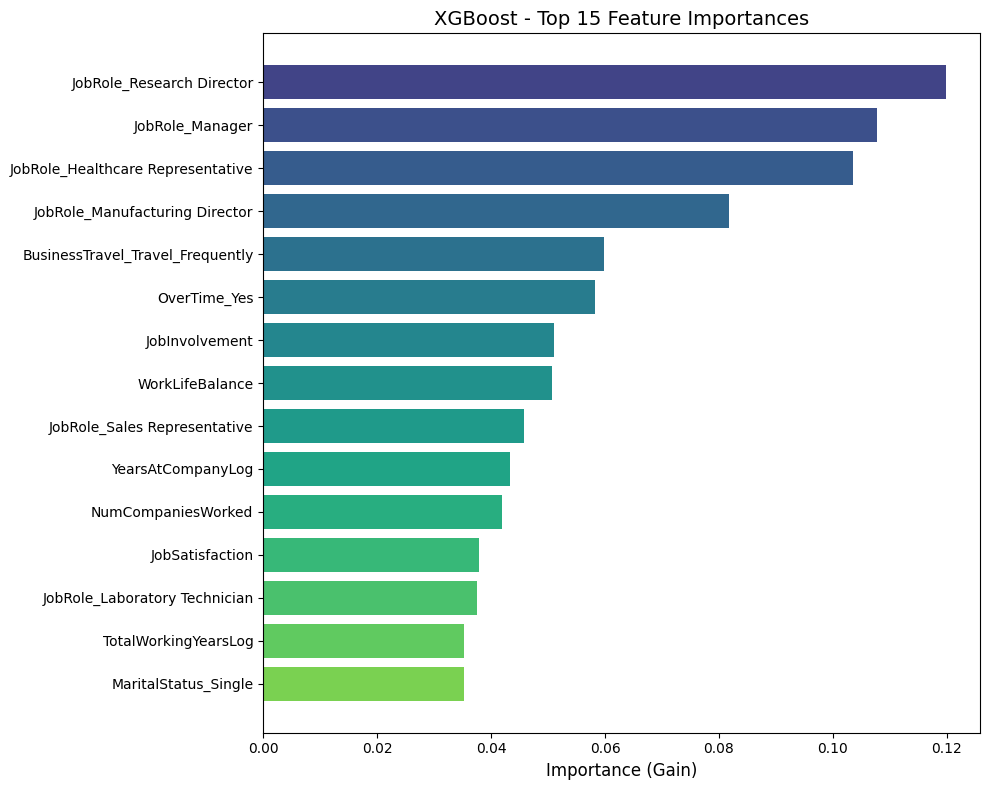


FEATURE IMPORTANCE RANKING
JobRole_Research Director                0.1198
JobRole_Manager                          0.1078
JobRole_Healthcare Representative        0.1036
JobRole_Manufacturing Director           0.0817
BusinessTravel_Travel_Frequently         0.0598
OverTime_Yes                             0.0583
JobInvolvement                           0.0510
WorkLifeBalance                          0.0506
JobRole_Sales Representative             0.0457
YearsAtCompanyLog                        0.0433
NumCompaniesWorked                       0.0419
JobSatisfaction                          0.0379
JobRole_Laboratory Technician            0.0375
TotalWorkingYearsLog                     0.0352
MaritalStatus_Single                     0.0352
Department_Research & Development        0.0349
EnvironmentSatisfaction                  0.0321
MaritalStatus_Married                    0.0237


In [11]:
# ============================================================
# FEATURE IMPORTANCE (XGBoost Native)
# ============================================================

# Get feature importance
feature_names = X_train.columns
importances = best_xgb.feature_importances_

# Create DataFrame and sort
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot top 15 features
top_n = 15
top_features = feature_importance.head(top_n)

plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_features)))
plt.barh(range(len(top_features)), top_features['Importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance (Gain)', fontsize=12)
plt.title('XGBoost - Top 15 Feature Importances', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Print feature importance table
print("\n" + "=" * 50)
print("FEATURE IMPORTANCE RANKING")
print("=" * 50)
for i, row in feature_importance.iterrows():
    print(f"{row['Feature']:<40} {row['Importance']:.4f}")


In [12]:
# ============================================================
# SAVE MODEL AND THRESHOLDS
# ============================================================

import joblib
import json
import os

# Create models directory
MODELS_PATH = 'models/'
os.makedirs(MODELS_PATH, exist_ok=True)

# Save the trained model
model_filename = os.path.join(MODELS_PATH, 'xgboost_attrition_model.joblib')
joblib.dump(best_xgb, model_filename)
print(f"Model saved to: {model_filename}")

# Save thresholds and metadata
model_metadata = {
    'model_type': 'XGBoost',
    'best_params': grid_search.best_params_,
    'cv_f1_score': float(grid_search.best_score_),
    'test_auc_score': float(auc_score),
    'thresholds': {
        'default': 0.5,
        'f1_optimized': float(f1_optimal_threshold),
        'recall_optimized': float(recall_optimal_threshold)
    },
    'target_recall': float(TARGET_RECALL),
    'feature_names': list(X_train.columns),
    'feature_importance': feature_importance.to_dict('records')
}

metadata_filename = os.path.join(MODELS_PATH, 'xgboost_model_metadata.json')
with open(metadata_filename, 'w') as f:
    json.dump(model_metadata, f, indent=4)
print(f"Metadata saved to: {metadata_filename}")



Model saved to: models/xgboost_attrition_model.joblib
Metadata saved to: models/xgboost_model_metadata.json
